# Product Recommendation System

## Project Objective

The goal of this project is to build a **product recommendation system** by leveraging **association rule mining** and **similarity-based techniques**. Specifically, the system:

- Identifies frequently co-purchased products using the **Apriori algorithm**
- Recommends similar products based on **Cosine Similarity**
- Supports personalized recommendations and product bundling strategies

This approach helps retailers improve **cross-selling**, **basket size**, and **customer satisfaction** by surfacing relevant product suggestions.


## Methods Used

### 1. **Apriori Algorithm** (Association Rule Mining)

- Used to discover **frequent itemsets** from transactional data
- Extracts **association rules** to find product combinations commonly bought together
- Helps suggest items for **bundled promotions** and **complementary product upsells**

**Example Rule:**  
`{Bread, Peanut Butter} → {Jam}`  
(If a customer buys bread and peanut butter, they are likely to buy jam)

---

### 2. **Cosine Similarity** (Item-Based Collaborative Filtering)

- Measures **similarity between product vectors** based on co-occurrence in transactions
- Suitable for sparse datasets where explicit ratings are unavailable
- Recommends similar products to what a user has previously bought



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_excel('Product Recommendations.xls',sheet_name = 'POS DATA')
df.head()

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,22-09-2014 22:45,Other Sauces
1,M09736,6468572,15669800,22-09-2014 22:45,Cashews
2,M09736,6468572,34989501,22-09-2014 22:45,Other Dals
3,M09736,6468572,7572303,22-09-2014 22:45,Namkeen
4,M09736,6468572,15669856,22-09-2014 22:45,Sugar


In [ ]:
# Create new Order date column
df['Created On'] = pd.to_datetime(df['Created On'], format="%d-%m-%Y %H:%M")
df['Order Date'] = df['Created On'].dt.date
df.drop('Created On', axis=1, inplace=True)
df['Weekday'] = pd.to_datetime(df['Order Date']).dt.day_name()

df.head()

,Member,Order,SKU,Description,Order Date,Weekday
0,M09736,6468572,34993740,Other Sauces,2014-09-22,Monday
1,M09736,6468572,15669800,Cashews,2014-09-22,Monday
2,M09736,6468572,34989501,Other Dals,2014-09-22,Monday
3,M09736,6468572,7572303,Namkeen,2014-09-22,Monday
4,M09736,6468572,15669856,Sugar,2014-09-22,Monday


In [ ]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
df.isnull().sum()

,0
Member,0
Order,0
SKU,0
Description,0
Order Date,0
Weekday,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62141 entries, 0 to 62140
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Member       62141 non-null  object
 1   Order        62141 non-null  int64 
 2   SKU          62141 non-null  int64 
 3   Description  62141 non-null  object
 4   Order Date   62141 non-null  object
 5   Weekday      62141 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


In [ ]:
# Count number of unique members
df['Member'].nunique()

106

In [ ]:
# Check number of product purchased and number of order placed by member id
grouped = df.groupby('Member').agg(num_product_purchased=('SKU', 'count'),num_orders_placed=('Order', 'nunique')).reset_index()
grouped.sort_values(by='Member',ascending=True,inplace=True)
grouped

,Member,num_product_purchased,num_orders_placed
0,M04158,493,132
1,M08075,638,55
2,M09303,463,105
3,M09736,626,62
4,M12050,556,39
...,...,...,...
101,M90375,412,79
102,M91098,483,66
103,M96365,402,73
104,M99030,594,78


## EDA

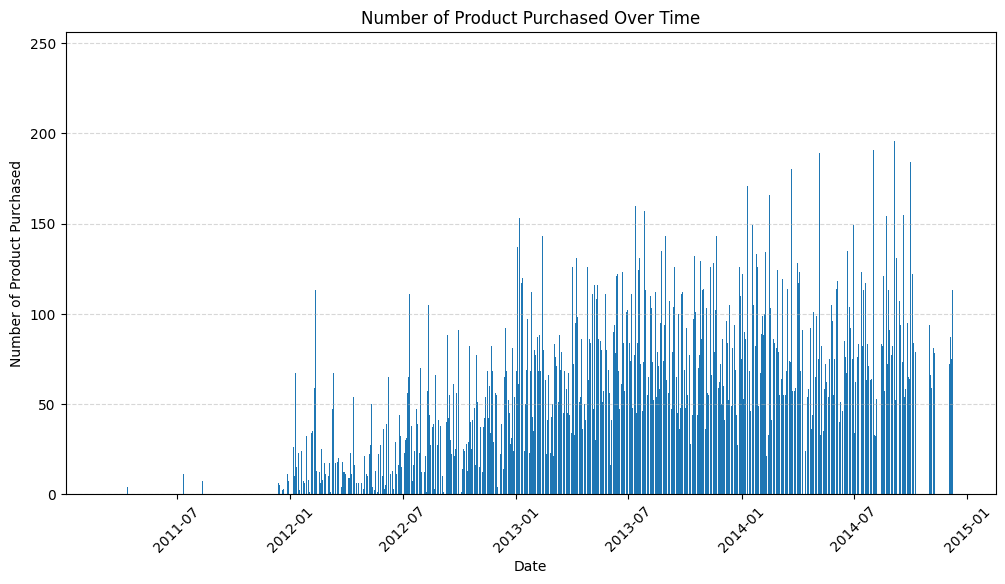

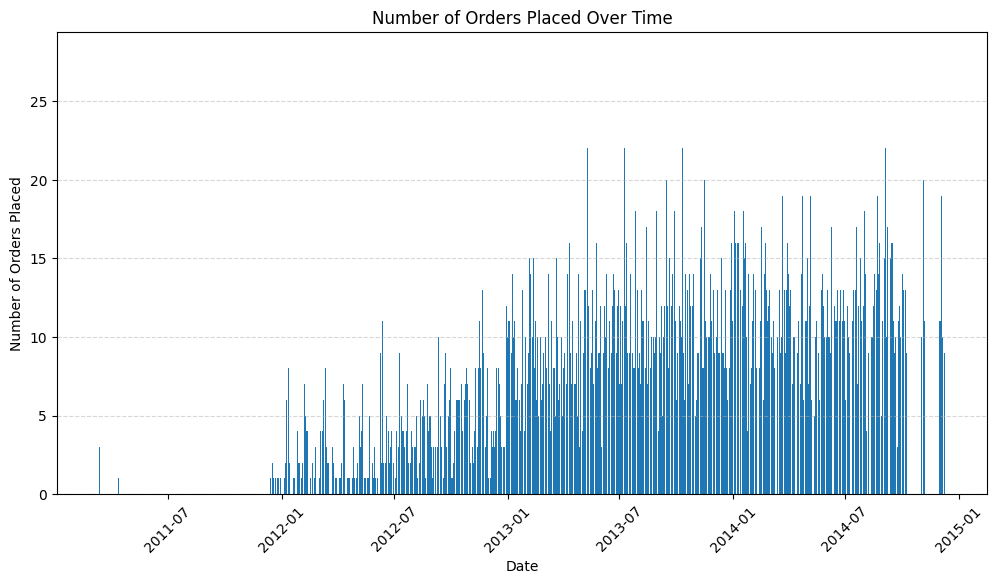

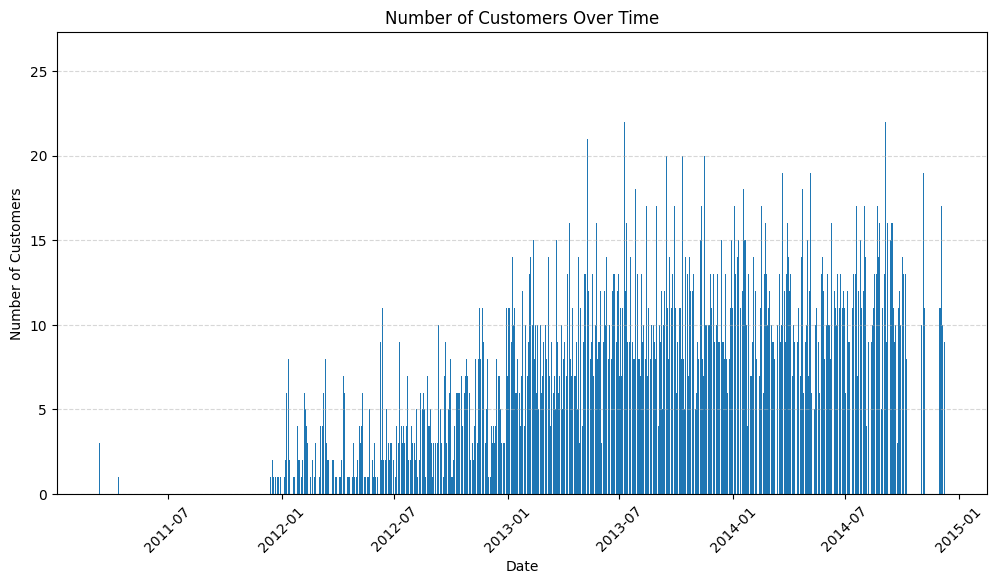

In [ ]:
#Count number of products, orders, and unique customers per day
skus_per_day = df.groupby('Order Date')['SKU'].count()
orders_per_day = df.groupby('Order Date')['Order'].nunique()
customers_per_day = df.groupby('Order Date')['Member'].nunique()


# Plot SKUs purchased over time
plt.figure(figsize=(12, 6))
plt.bar(skus_per_day.index, skus_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Product Purchased')
plt.title('Number of Product Purchased Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot Orders placed over time
plt.figure(figsize=(12, 6))
plt.bar(orders_per_day.index, orders_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Orders Placed')
plt.title('Number of Orders Placed Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot # Customers over time
plt.figure(figsize=(12, 6))
plt.bar(customers_per_day.index, customers_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Over Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


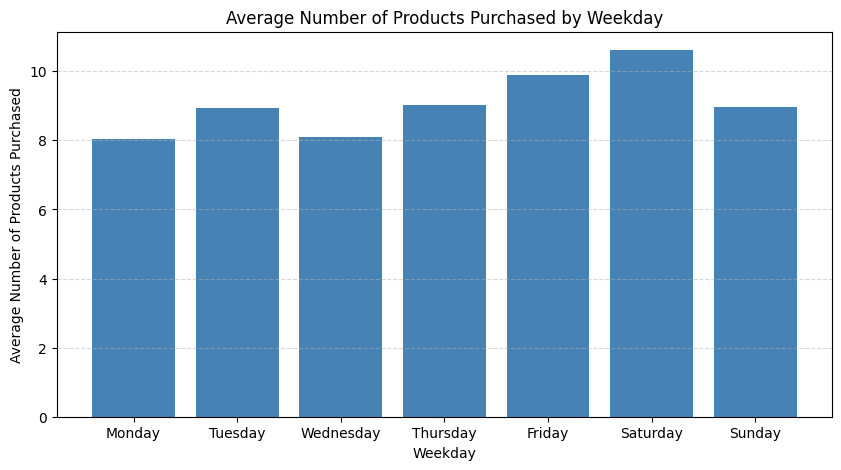

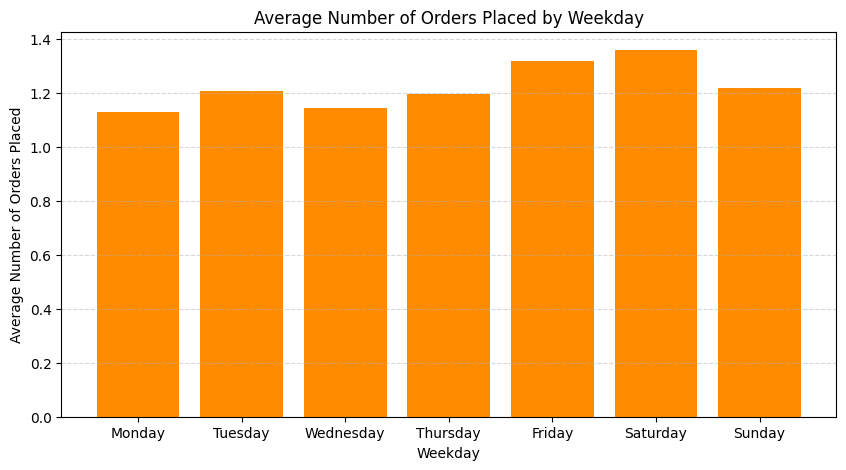

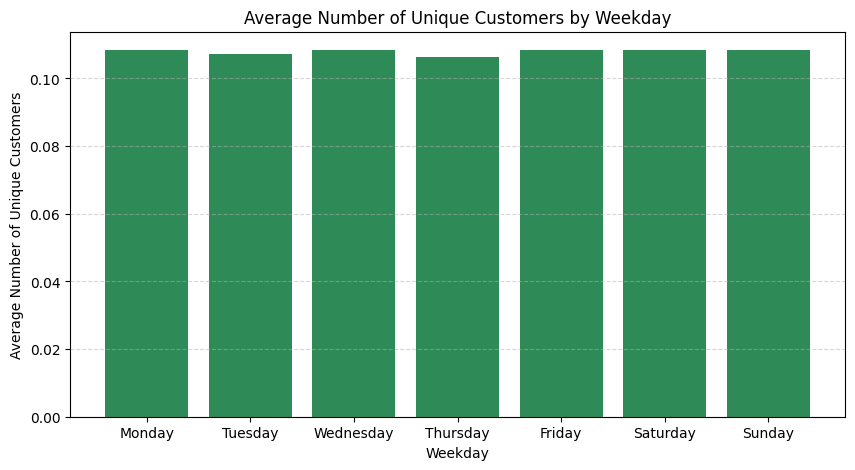

In [ ]:
 # Calculate the average number of SKUs purchased, orders placed, and unique customers per weekday
skus_per_weekday_avg = df.groupby('Weekday')['SKU'].count() / df['Order Date'].nunique()
orders_per_weekday_avg = df.groupby('Weekday')['Order'].nunique() / df['Order Date'].nunique()
customers_per_weekday_avg = df.groupby('Weekday')['Member'].nunique() / df['Order Date'].nunique()

# Reorder by correct weekday order
skus_per_weekday_avg = skus_per_weekday_avg.reindex(weekday_order)
orders_per_weekday_avg = orders_per_weekday_avg.reindex(weekday_order)
customers_per_weekday_avg = customers_per_weekday_avg.reindex(weekday_order)

# Plot SKUs purchased per weekday (average)
plt.figure(figsize=(10, 5))
plt.bar(skus_per_weekday_avg.index, skus_per_weekday_avg.values, color='steelblue')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Products Purchased')
plt.title('Average Number of Products Purchased by Weekday')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot Orders placed per weekday (average)
plt.figure(figsize=(10, 5))
plt.bar(orders_per_weekday_avg.index, orders_per_weekday_avg.values, color='darkorange')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Orders Placed')
plt.title('Average Number of Orders Placed by Weekday')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot Customers per weekday (average)
plt.figure(figsize=(10, 5))
plt.bar(customers_per_weekday_avg.index, customers_per_weekday_avg.values, color='seagreen')
plt.xlabel('Weekday')
plt.ylabel('Average Number of Unique Customers')
plt.title('Average Number of Unique Customers by Weekday')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


**Product Purchases per Order:**

This plot show the distribution of products pruchased per order, providing useful insights on the average basket size of order placed. The plot presents a right skewed distribution, suggesting only few of the orders includes large number of products, with most orders contain smaller basket size. The peak at around 6 products per order suggesting that majority of purchases have around 6 items, and is the most common basket size. The average basket size is around 7 products per order.

This suggest the smart basket size that we should made for clients, keep around 6-7 products in the baskets that match customer purchase behavior the most.

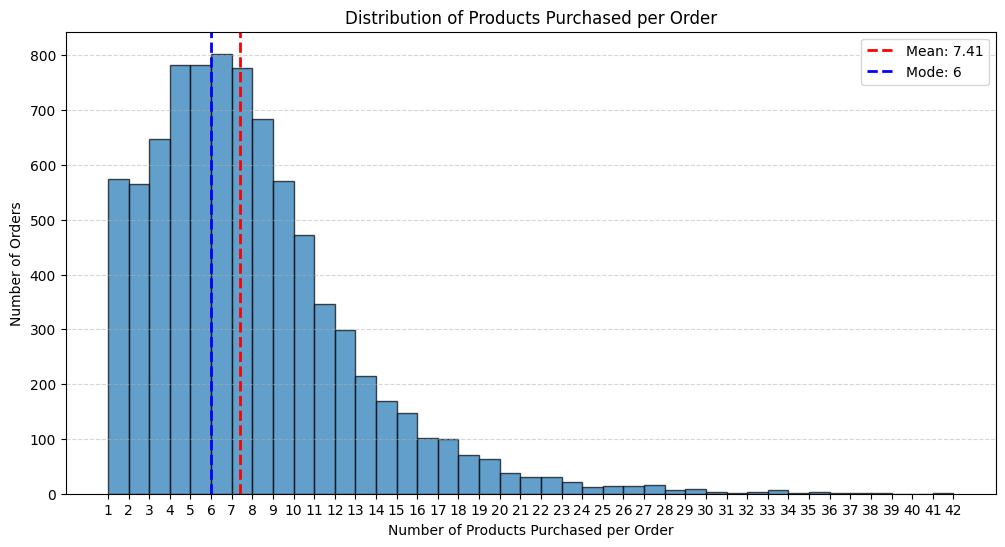

In [ ]:
# Count number of products purchased per order
sku_per_order = df.groupby('Order')['SKU'].count()

# Calculate mean and mode
mean_value = sku_per_order.mean()
mode_value = sku_per_order.mode()[0]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(sku_per_order, bins=range(1, sku_per_order.max() + 1), alpha=0.7, edgecolor='black')

# Plot mean and model line
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mode_value, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value}')

plt.xlabel('Number of Products Purchased per Order')
plt.ylabel('Number of Orders')
plt.title('Distribution of Products Purchased per Order')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(range(1, sku_per_order.max() + 1))
plt.legend()

plt.show()

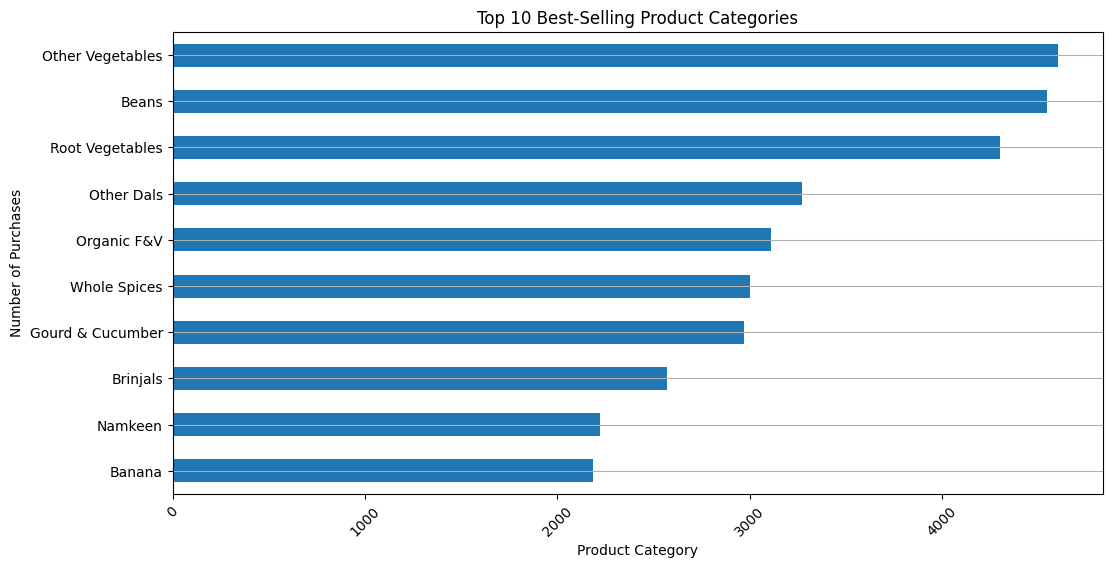

In [ ]:
#Count number of products purchased by product category, and show only the top 10 product categories
top_10_product_category = df['Description'].value_counts().head(10)

#Plot horizontal bar chart
plt.figure(figsize=(12, 6))
top_10_product_category.plot(kind='barh')
plt.xlabel('Product Category')
plt.ylabel('Number of Purchases')
plt.title('Top 10 Best-Selling Product Categories')
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.grid(axis='y')
plt.show()

## Apriori algorithm

The model includes 3 types of pruning, including

1. Support-based pruning: This process filters out the set that appear in less than set threshold percentage of transactions, excluding the infrequent items. The default is set at 0.2, which can filter out very rare items while still capturing a significant portion of meaningful, recurring patterns

2. Lift-based pruning: This process evaluate the association between products. With minimum lift threshold set at 1, it filters out the independent or negative association products, and only keep those with positive association, which products appear together more than expected.

3. Confidence-based pruning: This process evaluates the probability of consequents to be appeared with antecedents appear. With minimum confidence threshold set at 0.3, it filters out the consequents that appear less than 30% of the time of when antecedents appear.

In [ ]:
def smart_basket(df, member_id, m, min_support=0.2, min_confidence=0.3, min_lift=1):
    # Create df that only include member specific orders
    df_member = df[df['Member'] == member_id]

    # Calculate the number of orders per member
    order_counts = df.groupby('Member')['Order'].nunique()

    # Choose a threshold (mean)
    threshold = order_counts.mean()

    # Decide whether to use member-specific orders or all orders based on threshold
    if order_counts.get(member_id, 0) >= threshold:
        df_reference = df[df['Member'] == member_id]
    else:
        df_reference = df

    # Convert data to transaction format
    basket = df_member.pivot_table(index='Order', columns='Description', values='Member', aggfunc='count', fill_value=0)

    # Convert values to 1 or 0 (purchased or not purchased)
    basket = basket.map(lambda x: x > 0)

    # Find frequent itemsets using Apriori
    # Filter 1 - Keep itemset with minimum support
    frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)


    # Generate association rules from most frequent items
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)[['antecedents','consequents','antecedent support','consequent support','support','confidence','lift']]

    # Filter 2 - Minimum Confidence
    filtered_rules = rules[rules['confidence'] >= min_confidence]


    # Return list of final recommendation: frequently bought + suggested
    recommended_items = list(dict.fromkeys(
        [item for items in filtered_rules['antecedents'] for item in items] +
        [item for items in filtered_rules['consequents'] for item in items]
    ))

    return recommended_items[:min(m, len(recommended_items))]


In [ ]:
# Generate smart basket for member M09736 with 5 items
smart_basket(df, 'M04158', 5,min_support=0.02, min_confidence=0.3, min_lift=1)

['Almonds', 'Aluminium Foil & Cling Wrap', 'Health Drinks', 'Besan', 'Banana']

## Cosine similarity measure

In [ ]:
def cosine_similarity_member(df, member_id, n):
    # Create basket representation
    basket = df.pivot_table(index='Member', columns='Description', values='Order', fill_value=0)

    # Compute cosine similarity between all members
    similarity_matrix = cosine_similarity(basket)
    similarity_df = pd.DataFrame(similarity_matrix, index=basket.index, columns=basket.index)

    # Get the similarity scores for the given user
    similarity_scores = similarity_df[member_id]

    # Sort the similarity scores in descending order (excluding the user itself)
    similar_users = similarity_scores.sort_values(ascending=False).drop(member_id)

    # Identify the products already in the target member's basket
    current_products = basket.loc[member_id]
    current_products = current_products[current_products > 0].index.tolist()

    # Aggregate scores for candidate products from similar members
    candidate_scores = {}
    for other_member, sim_score in similar_users.items():
        # Find products that the other member has which the target member doesn't
        other_products = basket.loc[other_member]
        missing_products = [product for product, count in other_products.items() if count > 0 and product not in current_products]

        for product in missing_products:
            candidate_scores[product] = candidate_scores.get(product, 0) + sim_score

    # Sort the candidate products by their aggregated scores in descending order
    candidate_sorted = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
    recommended_products = [product for product, score in candidate_sorted[:n]]
    return recommended_products

In [ ]:
# Generate missing product list for member M09736 with 5 items
cosine_similarity_member(df, 'M09736', 5)

['Maida',
 'Exotic Vegetables',
 'Glucose, Marie & Milk Biscuits',
 'Honey',
 'Organic Masalas & Spices']